# Legacy 
This is a notebook that was used to calculate spot contrast values for spocon. 

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.nice(19)

19

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from glob import glob
import pandas as pd

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import trapz

# filter profile

In [3]:
filter_dir = '../input/filters/'
glob(filter_dir+'*')

['../input/filters/sdss_gp.txt',
 '../input/filters/pstr-zs-avg.txt',
 '../input/filters/Palomar_ZTF.r.dat',
 '../input/filters/sdss_ip.txt',
 '../input/filters/TP_MuSCAT2.csv',
 '../input/filters/Palomar_ZTF.g.dat',
 '../input/filters/Kepler_Kepler.K.dat',
 '../input/filters/sdss_rp.txt',
 '../input/filters/TESS_TESS.Red.dat']

In [4]:
bands = ['g', 'r', 'i', 'z',  #Sinistro
         'zg', 'zr',  #ZTF
         'k', 't', #Kepler, TESS
         'Mg', 'Mr', 'Mi', 'Mz'] #MuSCAT
bands

['g', 'r', 'i', 'z', 'zg', 'zr', 'k', 't', 'Mg', 'Mr', 'Mi', 'Mz']

In [5]:
filters = {}

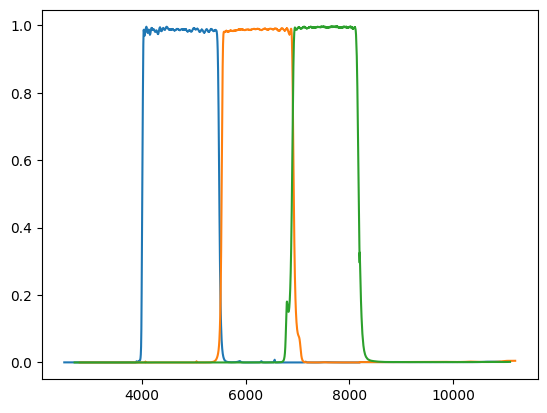

In [6]:
# Sinistro filters from https://lco.global/observatory/instruments/filters/

for b in ['g', 'r', 'i']:
    fil= pd.read_csv(filter_dir + f'sdss_{b}p.txt', sep='\t', skiprows=1, names=['wave[nm]', 'trans']) 
    fil['wave[A]']=fil['wave[nm]']*10
    pl.plot(fil['wave[A]'], fil['trans'])
    filters[b] = fil    

In [7]:
fil_z=pd.read_csv(filter_dir +'pstr-zs-avg.txt', sep='\t', header=None, names=['wave[nm]', 'trans', '-']) #LCO Zs
fil_z = fil_z.sort_values('wave[nm]').reset_index()
fil_z=fil_z.drop('index', axis=1)
fil_z['wave[A]']=fil_z['wave[nm]']*10
filters['z']=fil_z

In [8]:
fil_ztfg= pd.read_csv(filter_dir +'Palomar_ZTF.g.dat', sep='\s+', header=None, names=['wave[A]', 'trans']) #ZTF-g
fil_ztfg['wave[nm]']=fil_ztfg['wave[A]']/10
filters['zg']=fil_ztfg

fil_ztfr= pd.read_csv(filter_dir +'Palomar_ZTF.r.dat', sep='\s+', header=None, names=['wave[A]', 'trans']) #ZTF-r
fil_ztfr['wave[nm]']=fil_ztfr['wave[A]']/10
filters['zr']=fil_ztfr

In [9]:
fil_k=pd.read_csv(filter_dir +'Kepler_Kepler.K.dat', sep='\s+', header=None, names=['wave[A]', 'trans']) #Kepler
fil_k['wave[nm]']=fil_k['wave[A]']*0.1
filters['k']=fil_k

fil_t=pd.read_csv(filter_dir +'TESS_TESS.Red.dat', sep='\s+', header=None, names=['wave[A]', 'trans']) #TESS
fil_t['wave[nm]']=fil_t['wave[A]']*0.1
filters['t']=fil_t

In [11]:
fils_M = pd.read_csv(filter_dir +'TP_MuSCAT2.csv')
filters['Mg'] = pd.DataFrame({'wave[A]':fils_M['wavelength']*10,'trans':fils_M['Total_g']}).dropna().reset_index(drop=True)
filters['Mr'] = pd.DataFrame({'wave[A]':fils_M['wavelength']*10,'trans':fils_M['Total_r']}).dropna().reset_index(drop=True)
filters['Mi'] = pd.DataFrame({'wave[A]':fils_M['wavelength']*10,'trans':fils_M['Total_i']}).dropna().reset_index(drop=True)
filters['Mz'] = pd.DataFrame({'wave[A]':fils_M['wavelength']*10,'trans':fils_M['Total_z']}).dropna().reset_index(drop=True)

# plot

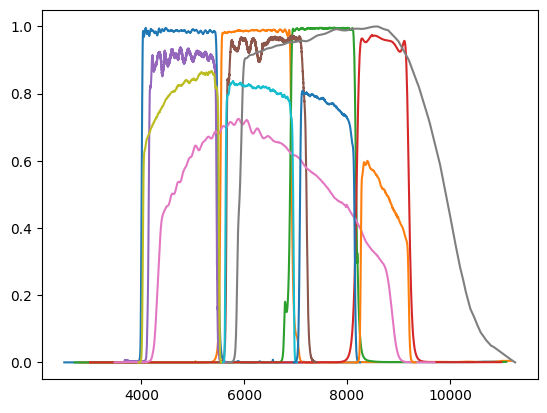

In [12]:
for b in bands:
    pl.plot(filters[b]['wave[A]'], filters[b]['trans'])

# stellar model - BT settl

In [13]:
filelist=glob('../input/models_BT_settl/BT-Settl_*.txt')
#filelist

In [14]:
#column 1: WAVELENGTH (ANGSTROM), Wavelength in Angstrom
# column 2: FLUX (ERG/CM2/S/A), Flux in erg/cm2/s/A

st_model={}

for file in filelist:
    key = file.split('_')[-1][:4]
    df = pd.read_csv(file, skiprows=8, sep='\s+', names=['wave[A]', 'flux'])
    df =df[(df['wave[A]']>2200)&(df['wave[A]']<11400)]
    df=df.reset_index(drop=True)
    
    st_model[int(key)]=df

In [15]:
keys = sorted(list(st_model.keys()))
np.array(keys)

array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800,
       3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900,
       5000])

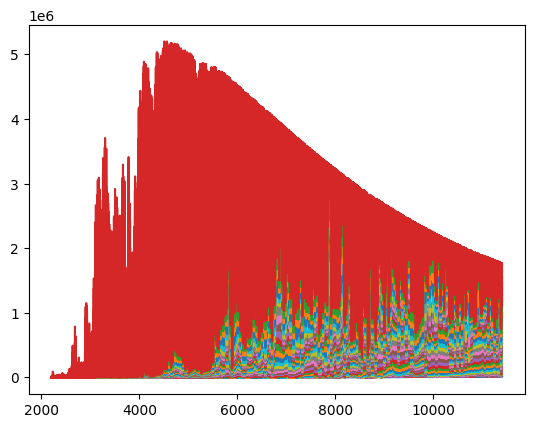

In [16]:
for key in keys:
    df = st_model[key]
    pl.plot(df['wave[A]'], df['flux'])

# contrast

from Notsu+13 & Morris+18  

$A_{spot} = amp_B \cdot A_{star}(1-c_B)^{-1}$  
$c_B = (\int_B F_{\lambda \cdot spot}T_\lambda d\lambda) / (\int_B F_{\lambda \cdot phot}T_\lambda d\lambda)$

then


$amp_g (1-c_g)^{-1} = amp_z (1-c_z)^{-1}$

In [18]:
st_crops_b={}

for b in bands:
    fil = filters[b]
    
    st_crops={}
    for key in keys:
        st=st_model[key]

        st_crop= st[(st['wave[A]']>fil['wave[A]'].iloc[0])&(st['wave[A]']<fil['wave[A]'].iloc[-1])].reset_index(drop=True)
        f = interp1d(fil['wave[A]'], fil['trans'],kind='linear')
        st_crop['trans']=f(st_crop['wave[A]'])
        st_crop['fltr']=st_crop['flux']*st_crop['trans']

        st_crops[key]=st_crop
    st_crops_b[b]=st_crops

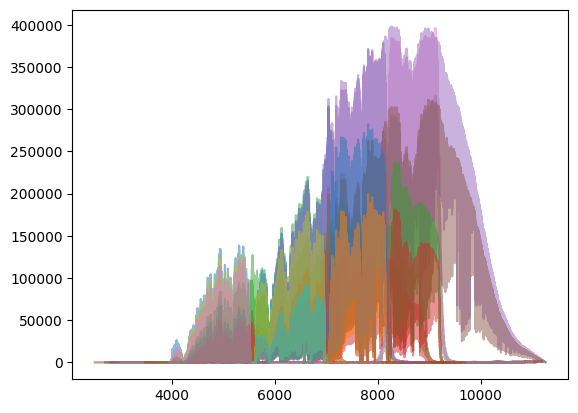

In [19]:
for b in bands:
    st = st_crops_b[b][3000]
    pl.plot(st['wave[A]'], st['fltr'], alpha=0.5)
    st = st_crops_b[b][2800]
    pl.plot(st['wave[A]'], st['fltr'], alpha=0.5)

In [21]:
for Tphot in keys:

    cs_b = {}

    for b in bands:
        cs=[]
        for key in keys:
            st = st_crops_b[b][key]
            st_phot=st_crops_b[b][Tphot]

            c =  trapz(st['fltr'], st['wave[A]'])/trapz(st_phot['fltr'], st_phot['wave[A]'])
            cs.append(c)
        cs_b[b]=cs

    df_con = pd.DataFrame({'Tspot':keys})

    for b in bands:
        df_con[b]=cs_b[b]

    df_con
    df_con.to_csv(f'../output/contrast_{Tphot}_new.csv')

# plot

In [22]:
#keys = np.arange(2500, 3500, 100)
keys = np.arange(1700, 5100, 100)
keys

array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800,
       3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900,
       5000])

In [23]:
df_contrasts = {}
for key in keys:
    cs=pd.read_csv(f'../output/contrast_{key}_new.csv').drop('Unnamed: 0', axis=1)
    df_contrasts[key]=cs

Text(0, 0.5, 'contrast')

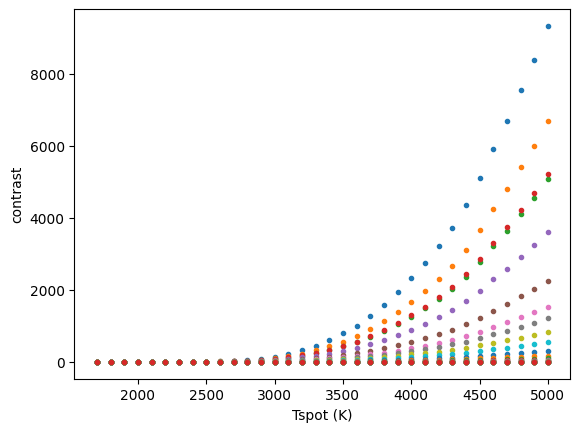

In [24]:
for tp in keys:
    cs = df_contrasts[tp]
    pl.plot(cs['Tspot'], cs['r'], '.')
pl.xlabel('Tspot (K)')
pl.ylabel('contrast')

In [25]:
def contrast_tmp(ts, tp, b, df_contrasts):
    cs = df_contrasts[tp]
    #cs = cs[cs['Tspot'] < tp]
    keys = np.array(cs['Tspot'])
    cs_b = cs[b]

    # Interpolate using scipy's interp1d
    f =interp1d(keys, cs_b, kind='cubic')
    interpolated_value = f(ts)

    return interpolated_value

Text(0, 0.5, 'contrast')

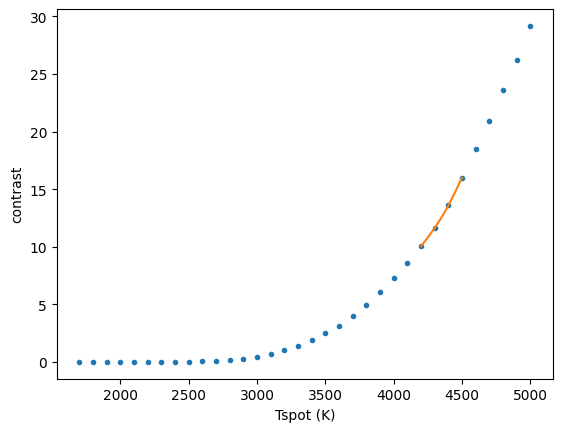

In [26]:
ts = np.arange(4200, 4500, 1)
tp = 3200
cs = df_contrasts[tp]
pl.plot(cs['Tspot'], cs['r'], '.')
pl.plot(ts, contrast_tmp(ts, tp, 'r', df_contrasts))
pl.xlabel('Tspot (K)')
pl.ylabel('contrast')

In [27]:
keys = np.array(sorted(df_contrasts.keys()))
ts_values = np.array(df_contrasts[keys[0]]['Tspot'])
Ts_mesh, Tp_mesh = np.meshgrid(ts_values, keys)
contrast_values = np.array([df_contrasts[key]['g'] for key in keys])

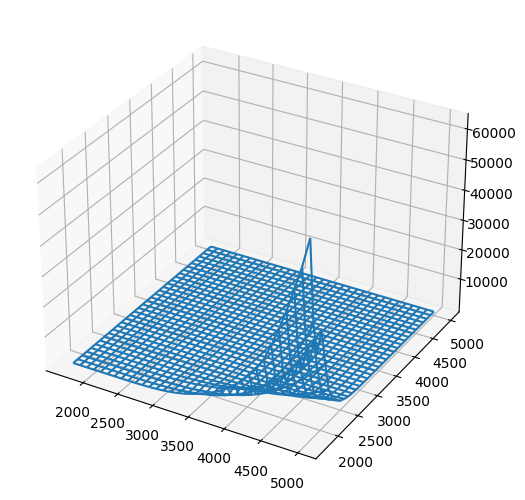

In [28]:
fig = pl.figure()
ax = Axes3D(fig)
fig.add_axes(ax)
ax.plot_wireframe(Ts_mesh, Tp_mesh,contrast_values)

In [29]:
from scipy.interpolate import interp2d

def contrast_tmp_continuous(Ts, Tp, b, df_contrasts):
    keys = np.array(sorted(df_contrasts.keys()))
    ts_values = np.array(df_contrasts[keys[0]]['Tspot'])
    Ts_mesh, Tp_mesh = np.meshgrid(ts_values, keys)

    contrast_values = np.array([df_contrasts[key][b] for key in keys])

    interp_func = interp2d(ts_values, keys, contrast_values, kind='cubic')
    interpolated_values = interp_func(Ts, Tp)

    return interpolated_values

In [30]:
contrast_tmp_continuous(3160, 3230, 'g', df_contrasts)

array([0.77180799])

Text(0, 0.5, 'contrast')

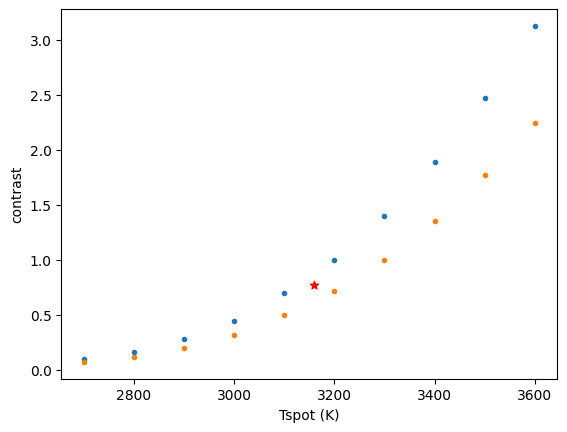

In [31]:
ts = 3160

cs = df_contrasts[3200][10:20]
pl.plot(cs['Tspot'], cs['r'], '.')

cs = df_contrasts[3300][10:20]
pl.plot(cs['Tspot'], cs['r'], '.')

pl.scatter([ts], contrast_tmp_continuous(ts, 3230, 'g', df_contrasts), marker='*',  color='red')
pl.xlabel('Tspot (K)')
pl.ylabel('contrast')